In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LEFT_EYE_LANDMARKS = [463, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374,
                            380, 381, 382, 362]  # Left eye landmarks
RIGHT_EYE_LANDMARKS = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145,
                            144, 163, 7]  # Right eye landmarks

In [3]:
def imshow(image, cmap=None):
  plt.imshow(image, cmap)
  plt.show()

In [ ]:
#http://benraynal.com/publis/AFIG07nat.pdf
class pupilDetector2007:
    def __init__(self):
        self.iris_color = None
        self.lowThreshMorpho = 0.2
        self.highThreshMorpho = 0.5
        self.threshColor = 0.85
        self.Cc = 0
        self.Cm = 0
        self.best_circle = None

    def detect_iris_color(self, eye_image, circle):
        """Compute the average color inside a reliable circle (strong morpho score)."""
        x, y, r = map(int, circle)
        mask = np.zeros(eye_image.shape[:2], dtype=np.uint8)
        cv2.circle(mask, (x, y), r, 255, -1)
        mean_color = cv2.mean(eye_image, mask=mask)[:3]
        self.iris_color = np.array(mean_color) / 255.0
        return self.iris_color

    def compute_Cm(self, eye_image):
        """Morphological coefficient: correlation between contour image and circular mask."""
        gray = cv2.cvtColor(eye_image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)

        h, w = edges.shape
        accumulator = np.zeros((h, w), dtype=np.float32)
        radii = range(10, min(h, w)//3, 2)

        for r in radii:
            mask = self._circular_mask(r)
            ys, xs = np.nonzero(edges)
            for y, x in zip(ys, xs):
                y1, y2 = y - r, y + r
                x1, x2 = x - r, x + r
                if y1 >= 0 and x1 >= 0 and y2 < h and x2 < w:
                    accumulator[y, x] += np.sum(mask)
        y0, x0 = np.unravel_index(np.argmax(accumulator), accumulator.shape)
        self.Cm = np.max(accumulator) / np.max(accumulator)
        self.best_circle = (x0, y0, radii[np.argmax(accumulator) % len(radii)])
        return self.Cm

    def compute_Cc(self, eye_image):
        """Colorimetric coefficient: similarity between candidate and iris color."""
        if self.iris_color is None or self.best_circle is None:
            return 0
        x, y, r = map(int, self.best_circle)
        mask = np.zeros(eye_image.shape[:2], dtype=np.uint8)
        cv2.circle(mask, (x, y), r, 255, -1)
        mean_color = np.array(cv2.mean(eye_image, mask=mask)[:3]) / 255.0
        kc = 1 - np.linalg.norm(mean_color - self.iris_color) / np.sqrt(3)
        self.Cc = kc
        return self.Cc

    def pass1(self, eye_image):
        """First pass: rough detection using Canny + circular masks."""
        self.compute_Cm(eye_image)
        if self.iris_color is not None:
            if self.Cm > self.lowThreshMorpho:
                self.compute_Cc(eye_image)
                if self.Cc > self.threshColor:
                    #Designe comme resultat le centre maximisant Cm * Cc
                    return True
        else:
            if self.Cm > self.highThreshMorpho:
                self.iris_color = self.detect_iris_color(eye_image, self.best_circle)
            return False

    def pass2(self, eye_image):
        """Second pass: refinement using elliptical masks or gradient radial."""
        # Simplified refinement: local search around best_circle
        if self.best_circle is None:
            return
        x, y, r = map(int, self.best_circle)
        gray = cv2.cvtColor(eye_image, cv2.COLOR_BGR2GRAY)
        roi = gray[max(0, y - r):y + r, max(0, x - r):x + r]
        edges = cv2.Canny(roi, 30, 100)
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, r/2, param1=50, param2=10, minRadius=r//2, maxRadius=int(r*1.2))
        if circles is not None:
            self.best_circle = tuple(map(int, circles[0][0]))

    def detect_pupil(self, eye_image):
        if self.pass1(eye_image):
            if self.pass2(eye_image):
                return self.best_circle
        return None

    def _circular_mask(self, r, thickness=2):
        """Generate Gaussian-weighted circular mask."""
        size = 2 * r + 1
        mask = np.zeros((size, size), dtype=np.float32)
        cv2.circle(mask, (r, r), r, 1, thickness)
        mask = cv2.GaussianBlur(mask, (3, 3), 0)
        return mask

            



In [4]:
def fit_ellipse_to_eye(landmarks, eye_landmarks, h , w):
    points = ([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in eye_landmarks])
    if len(points) >= 5:  # fitEllipse requires at least 5 points
        ellipse = cv2.fitEllipse(np.array(points))
        return ellipse, points
    return None, points

def extract_eye_region(frame, ellipse):
    eye_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.ellipse(eye_mask, ellipse, (255, 255, 255), -1)
    eye_region = cv2.bitwise_and(frame, frame, mask=eye_mask)
    return eye_region, eye_mask

def extract_pupil(eye_region, eye_mask):
    gray_eye = cv2.cvtColor(eye_region, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray_eye], [0], eye_mask, [256], [0, 256])
    gray_eye = cv2.equalizeHist(gray_eye)
    _, pupil = cv2.threshold(gray_eye, 50, 255, cv2.THRESH_BINARY_INV)
    pupil = cv2.bitwise_and(pupil, pupil, mask=eye_mask)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil, connectivity=8)
    imshow(gray_eye, cmap='gray')
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        pupil = np.zeros_like(pupil)
        pupil[labels == largest_label] = 255
    return pupil

def extract_pupil_better(eye_region, eye_mask):
    #filter out the red
    eye_region_hsv = cv2.cvtColor(eye_region, cv2.COLOR_BGR2HSV)
    
    gray_eye = cv2.cvtColor(eye_region, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray_eye], [0], eye_mask, [256], [0, 256])
    gray_eye = cv2.equalizeHist(gray_eye)

    
    #extract the darkest 5% of pixels in the eye region
    threshold_value = np.percentile(gray_eye[eye_mask == 255], 5)
    _, pupil = cv2.threshold(gray_eye, threshold_value, 255, cv2.THRESH_BINARY_INV)
    pupil = cv2.bitwise_and(pupil, pupil, mask=eye_mask)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil, connectivity=8)
    imshow(gray_eye, cmap='gray')
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        pupil = np.zeros_like(pupil)
        pupil[labels == largest_label] = 255
        return pupil

def extract_pupil3(eye_region, eye_mask):
    gray_eye = cv2.cvtColor(eye_region, cv2.COLOR_BGR2GRAY)
    gray_eye = cv2.equalizeHist(gray_eye)

    threshold_value = np.percentile(gray_eye[eye_mask == 255], 65)
    _, iris = cv2.threshold(gray_eye, threshold_value, 255, cv2.THRESH_BINARY_INV)
    iris = cv2.bitwise_and(iris, iris, mask=eye_mask)
    #close circle
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    iris = cv2.morphologyEx(iris, cv2.MORPH_CLOSE, kernel)
    #open circle 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    iris = cv2.morphologyEx(iris, cv2.MORPH_OPEN, kernel)

    print("this is the iris : ")
    imshow(iris, cmap='gray')
    
    #find the pupil as the darkest part of the iris
    iris_gray = cv2.bitwise_and(gray_eye, gray_eye, mask=iris)
    iris_gray = cv2.equalizeHist(iris_gray)

    print("this is the iris gray : ")
    imshow(iris_gray, cmap='gray')

    threshold_value = np.percentile(iris_gray[iris == 255], 10)
    _, pupil = cv2.threshold(iris_gray, 25, 255, cv2.THRESH_BINARY_INV)

    print("this is the pupil before mask : ")
    imshow(pupil, cmap='gray')
    
    pupil = cv2.bitwise_and(pupil, pupil, mask=iris)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil, connectivity=8)
    
    
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        pupil = np.zeros_like(pupil)
        pupil[labels == largest_label] = 255

    print("this is the pupil : ")
    imshow(pupil, cmap='gray')
    
    return pupil
   


this is the iris : 


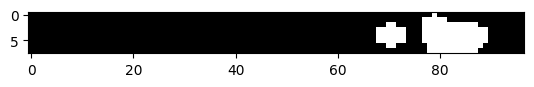

this is the iris gray : 


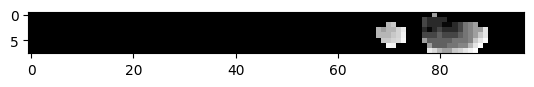

this is the pupil before mask : 


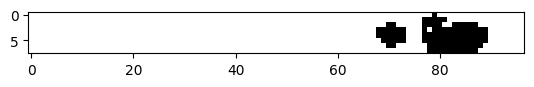

this is the pupil : 


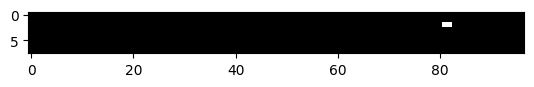

this is the iris : 


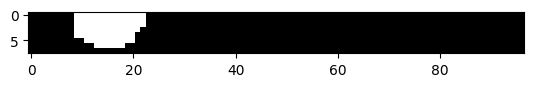

this is the iris gray : 


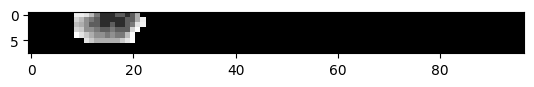

this is the pupil before mask : 


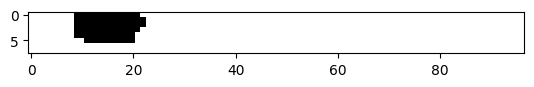

this is the pupil : 


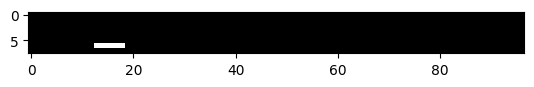

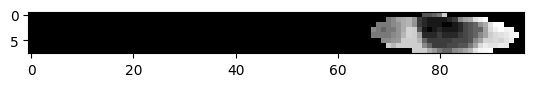

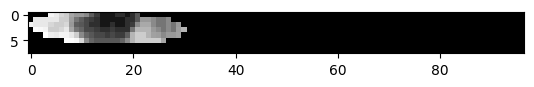

good pupil : 


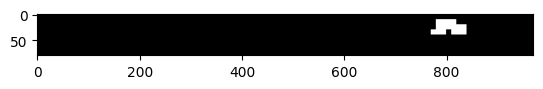

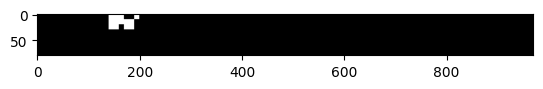

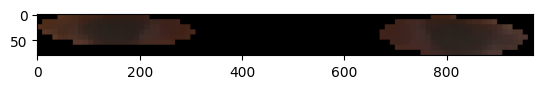

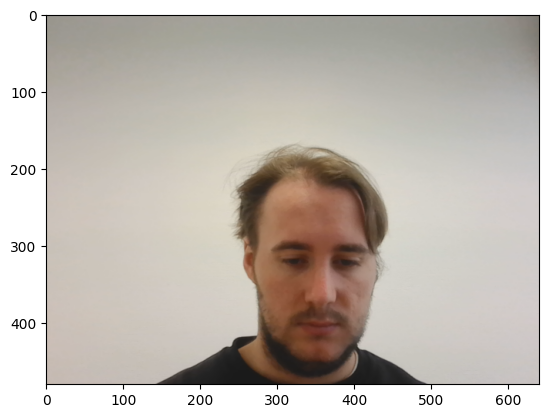

In [8]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

cap = cv2.VideoCapture(0)

if cap.isOpened():
    success, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
results = face_mesh.process(frame_rgb)

h, w, _ = frame.shape


if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:

        #fit ellipse to left eye points
        left_eye_ellipse, left_eye_points = fit_ellipse_to_eye(face_landmarks.landmark, LEFT_EYE_LANDMARKS, h, w)
        right_eye_ellipse, right_eye_points = fit_ellipse_to_eye(face_landmarks.landmark, RIGHT_EYE_LANDMARKS, h, w)
        # extraie deux images au niveau des ellipses

        if left_eye_ellipse is not None and right_eye_ellipse is not None:
            # Crée un masque pour les yeux
            left_eye_img, left_eye_mask = extract_eye_region(frame, left_eye_ellipse)
            right_eye_img, right_eye_mask = extract_eye_region(frame, right_eye_ellipse)
            # Combine les deux images des yeux
            eyes = cv2.bitwise_or(left_eye_img, right_eye_img)
            
            # Recadre autour des yeux
            x, y, w_box, h_box = cv2.boundingRect(np.array(left_eye_points + right_eye_points))
            eyes_cropped = eyes[y:y+h_box, x:x+w_box]
            left_eye_img = left_eye_img[y:y+h_box, x:x+w_box]
            right_eye_img = right_eye_img[y:y+h_box, x:x+w_box]
            
            # Extraie les pupilles
            left_pupil = extract_pupil3(left_eye_img, left_eye_mask[y:y+h_box, x:x+w_box])
            right_pupil = extract_pupil3(right_eye_img, right_eye_mask[y:y+h_box, x:x+w_box])

            left_pupil2 = extract_pupil_better(left_eye_img, left_eye_mask[y:y+h_box, x:x+w_box])
            right_pupil2 = extract_pupil_better(right_eye_img, right_eye_mask[y:y+h_box, x:x+w_box])

            #get the centroid of each pupil
            M_left = cv2.moments(left_pupil)
            M_right = cv2.moments(right_pupil)

            #draw the centroid on the original frame
            if M_left["m00"] != 0:
                cX_left = int(M_left["m10"] / M_left["m00"]) + x
                cY_left = int(M_left["m01"] / M_left["m00"]) + y
                cv2.circle(frame, (cX_left, cY_left), 2, (0, 255, 0), -1)
            if M_right["m00"] != 0:
                cX_right = int(M_right["m10"] / M_right["m00"]) + x
                cY_right = int(M_right["m01"] / M_right["m00"]) + y
                cv2.circle(frame, (cX_right, cY_right), 2, (0, 255, 0), -1)

            left_pupil = cv2.resize(left_pupil, (0, 0), fx=10, fy=10, interpolation=cv2.INTER_NEAREST)  # Redimensionne pour une meilleure visibilité
            right_pupil = cv2.resize(right_pupil, (0, 0), fx=10, fy=10, interpolation=cv2.INTER_NEAREST)  # Redimensionne pour une meilleure visibilité

            
            left_pupil2 = cv2.resize(left_pupil2, (0, 0), fx=10, fy=10, interpolation=cv2.INTER_NEAREST)  # Redimensionne pour une meilleure visibilité
            right_pupil2 = cv2.resize(right_pupil2, (0, 0), fx=10, fy=10, interpolation=cv2.INTER_NEAREST)  # Redimensionne pour une meilleure visibilité

            print("good pupil : ")
            imshow(left_pupil2, cmap='gray')
            imshow(right_pupil2, cmap='gray')
            
            eyes_cropped = cv2.resize(eyes_cropped, (0, 0), fx=10, fy=10, interpolation=cv2.INTER_NEAREST)  # Redimensionne pour une meilleure visibilité
            
            imshow(cv2.cvtColor(eyes_cropped, cv2.COLOR_BGR2RGB))
            imshow(frame_rgb)

cap.release()
cv2.destroyAllWindows()

In [15]:
import torch
#show if cuda is available
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [6]:
#load face_data1760983065.csv
import pandas as pd
data = pd.read_csv("face_data1760983292.csv")

diff = data["left eye X"] - data["left_pupil X"]
print("max diff left eye X:", diff.max() * 640)
print("min diff left eye X:", diff.min() * 640)

max diff left eye X: 10.0
min diff left eye X: -8.999999999999986
